# <center>DataLab Cup 4: Recommender Systems</center>
<center>Shan-Hung Wu & DataLab</center>
<center>Fall 2023</center>

## Platform: [Kaggle](https://www.kaggle.com/t/b06e248a3827434f80c4fdc6009d5fe0)

Please download the dataset and the environment source code from Kaggle.

## Overview

In this competition, your goal is to design a recommender system that suggests news articles to users. The performance of your recommender system will be assessed using a simulation environment.

At each timestep, the simulation environment randomly selects an active user with a given `user_id`. Once you receive this `user_id`, your recommender system must generate a slate **(a list of 5 distinct `item_ids` to recommend to the current user)** and pass it to the environment. The environment then uses its internal information to determine which item the user will choose from the recommended list (with some degree of stochasticity) or decide not to choose any item due to a lack of interest.

Each user has a latent patience value (invisible to your recommender system), which slightly increases when an item is chosen and drastically decreases when no item is chosen in each round. If a user's patience drops below 0 or the user runs out of the time budget (2000 timesteps), the user leaves the environment. The chosen `item_id` (or `-1` if no item is chosen) and whether the current user stays (`True`) or leaves (`False`) are returned as the result of recommending a slate of items. A new user (if any) will be randomly selected for recommendations in the next timestep after the response of the current user is generated.

Your recommender system should continue recommending items to the current user at each timestep as long as there are still active users in the environment. The simulation process terminates after all users have left the system.

**Your goal is to maximize the session length of each user.** The session length is defined as the number of timesteps a user interacts with your recommender system before leaving the environment. The calculated session length score, normalized to the range of 0 ~ 1, will be provided by the simulation environment after the completion of the simulation process.

In [1]:
import os
import random

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

from evaluation.environment import TrainingEnvironment, TestingEnvironment

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
# Official hyperparameters for this competition (do not modify)
N_TRAIN_USERS = 1000
N_TEST_USERS = 2000
N_ITEMS = 209527
HORIZON = 2000
TEST_EPISODES = 5
SLATE_SIZE = 5

## Datasets

In this competition, we won't provide a substantial user-item interaction dataset. Instead, limited information (3 items per user) on historical interactions will be available. To train your recommender system effectively, you need to employ a recommender policy to interact with the training environment and collect additional interaction data.

We will introduce the side-information datasets provided in the following sections.

In [4]:
# Dataset paths
USER_DATA = os.path.join('dataset', 'user_data.json')
ITEM_DATA = os.path.join('dataset', 'item_data.json')

# Output file path
OUTPUT_PATH = os.path.join('output', 'output.csv')

## User Data

In the **training environment**, there are a total of **1000 users** identified by IDs ranging from 0 to 999. For the **testing environment**, there are **2000 users** with IDs ranging from 0 to 1999. The **testing environment includes the same 1000 users found in the training environment** (user 0 to user 999), and an additional 1000 new users (user 1000 to user 1999) are introduced.

For all 2000 users, we provide you with the **past 3 clicked item IDs of each user**. Let's examine the user dataset.

In [5]:
df_user = pd.read_json(USER_DATA, lines=True)
df_user

,user_id,history,non_click
0,0,"[65272, 13353, 62006, 42558]","[104449, 190467, 157700, 28682, 167947, 118802..."
1,1,"[170112, 159877, 146057, 141458, 197398, 15861...","[57354, 151563, 133138, 135188, 96277, 67608, ..."
2,2,"[67551, 85247, 33714]","[141318, 190479, 159759, 194577, 208913, 10259..."
3,3,"[116097, 192703, 123460, 172366, 199798, 13973...","[112647, 14345, 129036, 190479, 159782, 176167..."
4,4,"[166371, 203817, 154254, 201649, 68756, 135289...","[122882, 108565, 110620, 63533, 77871, 54, 778..."
...,...,...,...
1995,1995,"[95090, 131393, 130239]",[]
1996,1996,"[2360, 147130, 8145]",[]
1997,1997,"[99794, 138694, 157888]",[]
1998,1998,"[55561, 60372, 51442]",[]


In [6]:
origin_user = pd.read_json('./dataset/origin_user_data.json', lines=True)
origin_user

,user_id,history
0,0,"[42558, 65272, 13353]"
1,1,"[146057, 195688, 143652]"
2,2,"[67551, 85247, 33714]"
3,3,"[116097, 192703, 103229]"
4,4,"[68756, 140123, 135289]"
...,...,...
1995,1995,"[95090, 131393, 130239]"
1996,1996,"[2360, 147130, 8145]"
1997,1997,"[99794, 138694, 157888]"
1998,1998,"[55561, 60372, 51442]"


In [7]:
# for i in range(2000):
#     df_user['non_click'][i] = []
# df_user.to_json(USER_DATA, orient='records', lines=True)

## Item Data

Both the training and testing environments share a common pool of **209527 items** as their item candidate pool. For the side information of these items, we provide text descriptions for each news article. The item dataset is derived from the [News Category Dataset](https://www.kaggle.com/datasets/rmisra/news-category-dataset). It's important to note that you should only use the dataset provided by us. Utilizing the original dataset, which contains extra information, will be considered as cheating. Let's explore the item dataset.

In [8]:
df_item = pd.read_json(ITEM_DATA, lines=True)
df_item

,item_id,headline,short_description
0,0,Over 4 Million Americans Roll Up Sleeves For O...,Health experts said it is too early to predict...
1,1,"American Airlines Flyer Charged, Banned For Li...",He was subdued by passengers and crew when he ...
2,2,23 Of The Funniest Tweets About Cats And Dogs ...,"""Until you have a dog you don't understand wha..."
3,3,The Funniest Tweets From Parents This Week (Se...,"""Accidentally put grown-up toothpaste on my to..."
4,4,Woman Who Called Cops On Black Bird-Watcher Lo...,Amy Cooper accused investment firm Franklin Te...
...,...,...,...
209522,209522,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,Verizon Wireless and AT&T are already promotin...
209523,209523,Maria Sharapova Stunned By Victoria Azarenka I...,"Afterward, Azarenka, more effusive with the pr..."
209524,209524,"Giants Over Patriots, Jets Over Colts Among M...","Leading up to Super Bowl XLVI, the most talked..."
209525,209525,Aldon Smith Arrested: 49ers Linebacker Busted ...,CORRECTION: An earlier version of this story i...


In [9]:
# from sentence_transformers import SentenceTransformer

# # Instantiate the SentenceTransformer model
# model = SentenceTransformer('all-MiniLM-L6-v2')

# # Compute embeddings for headlines
# headline_embeddings = model.encode(df_item['headline'].to_list(), show_progress_bar=True)

# # Compute embeddings for short descriptions
# description_embeddings = model.encode(df_item['short_description'].to_list(), show_progress_bar=True)

In [10]:
# np.save('./dataset/headline_embeddings.npy', headline_embeddings)
# np.save('./dataset/description_embeddings.npy', description_embeddings)

In [11]:
headline_embeddings = np.load('./dataset/headline_embeddings.npy')
description_embeddings = np.load('./dataset/description_embeddings.npy')
print('Headline embedding shape:', headline_embeddings.shape)
print('description embeddings shape:', description_embeddings.shape)

Headline embedding shape: (209527, 384)
description embeddings shape: (209527, 384)


In [12]:
headline_weight = 2
description_weight = 1
item_embeddings = (headline_embeddings * headline_weight + description_embeddings * description_weight) / (headline_weight + description_weight)
print('Item embedding shape: ',item_embeddings.shape)

Item embedding shape:  (209527, 384)


## Simulation Environments

We offer two simulation environments in this competition: `TrainingEnvironment` and `TestingEnvironment`. The only distinction between the two environments is the number of users, with 1000 for training and 2000 for testing. All public methods for both environments behave the same since they share the same base class.

**Important Note: Ensure that you collect interaction data only by accessing the environment through the designated public methods listed below. Directly accessing or modifying any file or code in the `evaluation` directory, or retrieving internal attributes and states of the environment (including all attributes / methods starting with an underscore `_`), will be considered as cheating.**

## Environment Classes

### <kbd>class</kbd> `TrainingEnvironment`
Class for the training environment. Contains first 1000 users with user ID ranging from 0 to 999. 

### <kbd>class</kbd> `TestingEnvironment`
Class for the testing environment. Contains all 2000 users with user ID ranging from 0 to 1999. 

## Environment Public Methods

**Note that both `TrainingEnvironment` and `TestingEnvironment` shares the same set of public methods.**

---

### <kbd>function</kbd> `reset`


```python
reset() → None
```

<br/>
Reset the environment to its initial parameters and states. 

---

### <kbd>function</kbd> `has_next_state`


```python
has_next_state() → bool
```

<br/>
Verify whether the next state exists. The next state is considered to exist if there is at least one user still present in the environment. 

**Returns:**

  - `True` if the next state exists, `False` otherwise. 

---

### <kbd>function</kbd> `get_state`


```python
get_state() → int
```

<br/>
Get the current state (the user ID of the current user). 

**Returns:**
 
 - <b>``int``</b>:  The user ID of the current user, or `-1` if there are no active users in the environment. 

---

### <kbd>function</kbd> `get_response`


```python
get_response(slate: list) → tuple[int, bool]
```

<br/>
Send the recommended slate (list of 5 distinct item IDs) and get the response from the current user. The internal user state will be updated according to the response, and a random user will be selected to be the next user (next state). 

**Args:**
 
 - <b>`slate`</b>:  `list[int]`  A list of 5 distinct item IDs to be recommended. 

**Returns:**

 - <b>`tuple[int, bool]`</b>:  The first entry indicates the `item ID` chosen by the user, or `-1` if the user decides not to choose any item.  The second entry represents whether the user is still in the environment after this interaction round. `True` if the user stays, `False` if the user leaves. 

**Raises:**
 
 - <b>``AssertionError``</b>:  If the slate length is not 5, contains duplicates or out-of-range item IDs, or if there are no active users in the environment. 

---

### <kbd>function</kbd> `get_score`


```python
get_score() → list[float]
```

<br/>
Get the normalized session length score (0 ~ 1) for each user. 

**Returns:**
 
 - <b>``list[float]``</b>:  A list containing the normalized session length score for each user. 

In [13]:
LR = 1e-4
BATCH_SIZE = 32

optimizer = tf.optimizers.Adam(learning_rate=LR)

In [14]:
class NewsRecommender(tf.Module):
    def __init__(self, user_data, item_embeddings):
        super(NewsRecommender, self).__init__()
        self.item_embeddings = tf.Variable(item_embeddings)
        self.item_bias = tf.Variable(np.zeros(item_embeddings.shape[0]), dtype=tf.float32)
        self.user_embeddings = tf.Variable(self.initialize_user_embeddings(user_data, self.item_embeddings))
        self.user_bias = tf.Variable(np.zeros(len(user_data)), dtype=tf.float32)

    def initialize_user_embeddings(self, user_data, item_embeddings):
        user_embeddings = []
        for history in user_data['history']:
            history_embeddings = tf.gather(item_embeddings, history)
            user_embedding = tf.reduce_mean(history_embeddings, axis=0)
            user_embeddings.append(user_embedding)
    
        return tf.stack(user_embeddings)
    
    @tf.function
    def train_step(self, interact_sparse):
        with tf.GradientTape() as tape:
            # Get the dense user and item factors from the embedding matrices for the batch
            user_embed = tf.nn.embedding_lookup(self.user_embeddings, interact_sparse.indices[:, 0])
            item_embed = tf.nn.embedding_lookup(self.item_embeddings, interact_sparse.indices[:, 1])
            user_b = tf.gather(self.user_bias, interact_sparse.indices[:, 0])
            item_b = tf.gather(self.item_bias, interact_sparse.indices[:, 1])

            # Compute the predictions
            pred = tf.reduce_sum(user_embed * item_embed, axis=1) + user_b + item_b

            # Compute the loss using binary cross-entropy
            loss = tf.keras.losses.binary_crossentropy(interact_sparse.values, pred, from_logits=True)

        # Get gradients
        grads = tape.gradient(loss, self.trainable_variables)

        # Apply gradients
        optimizer.apply_gradients(zip(grads, self.trainable_variables))

        return loss

    # @tf.function
    def recommend(self, user_id, history):
        # get user embedding
        user_vector = tf.gather(self.user_embeddings, user_id)
        user_b = tf.gather(self.user_bias, user_id)

        # calculate the score between the user and all items embedding
        scores = tf.reduce_sum(user_vector * self.item_embeddings, axis=1) + user_b + self.item_bias
        scores = tf.reshape(scores, [-1])
        
        history_indices = tf.constant([[i] for i in history], dtype=tf.int64)
        updates = tf.fill([len(history)], tf.float32.min)
        scores = tf.tensor_scatter_nd_update(scores, history_indices, updates)
                
        # get top-5 score
        _, top_indices = tf.math.top_k(scores, k=SLATE_SIZE)

        return top_indices.numpy()
    
    # @tf.function
    def update_response(self, user_ids, item_ids, isClick):
        with tf.GradientTape() as tape:
            # Get the dense user and item factors from the embedding matrices for the batch
            user_embed = tf.nn.embedding_lookup(self.user_embeddings, user_ids)
            item_embed = tf.nn.embedding_lookup(self.item_embeddings, item_ids)
            user_b = tf.gather(self.user_bias, user_ids)
            item_b = tf.gather(self.item_bias, item_ids)
            
            # Compute the predictions
            logits = tf.reduce_sum(user_embed * item_embed, axis=1) + user_b + item_b
            
            pred = tf.sigmoid(logits)
            
            # Compute loss
            loss = tf.maximum(0.0, 1 - pred) if isClick else pred
        
        # Get gradients
        grads = tape.gradient(loss, self.trainable_variables)

        # Apply gradients
        optimizer.apply_gradients(zip(grads, self.trainable_variables))
        
        return loss

In [15]:
recommender = NewsRecommender(df_user, item_embeddings)
checkpoint_dir = './checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=recommender)

In [16]:
# restore
checkpoint.restore('./checkpoints/ckpt-60')

In [17]:
recommender.recommend(0, df_user['history'][0])

array([ 59989, 184546,   8533, 150805, 163488])

## Training

The implementation of the recommender algorithm is left to you. If you're in need of ideas, you can refer to the [Recommender Systems Tutorial](https://nthu-datalab.github.io/ml/labs/recommender-systems-tutorial/recommender-systems-tutorial.html) notebook in Lecture 16. Here, we'll just provide some example use cases of the public methods.

**Hint:** If you're looking for inspiration, consider starting by collecting interaction data from the environment using your initial recommender policy. Afterward, improve your model with this data, and iterate through this collect-then-train loop.

**Important Note: Ensure that you save your model weights after training. You will need to load a set of model weights trained exclusively on the training environment at the beginning of each test episode.**

In [18]:
def initialize_interaction_matrix(user_data, item_length):
    indices = [] 
    values = []  

    for user_id, user_history in enumerate(user_data['history']):
        for item_id in user_history:
            indices.append([user_id, item_id])
            values.append(1)  # if click
    
    for user_id, user_non_click in enumerate(user_data['non_click']):
        for item_id in user_non_click:
            if([user_id, item_id] in indices): continue
            indices.append([user_id, item_id])
            values.append(0)

    # init sparse matrix
    interaction_matrix = tf.sparse.SparseTensor(indices, values, dense_shape=[len(user_data), item_length])

    # order sparse matrix
    interaction_matrix = tf.sparse.reorder(interaction_matrix)

    return interaction_matrix

### Training Based On user data (Offline Learning)

In [28]:
# EPOCHS = 10

# # init interaction matrix
# interaction_matrix = initialize_interaction_matrix(df_user, item_embeddings.shape[0])

# # prepare datasets
# dataset_train = tf.data.Dataset.from_tensor_slices(interaction_matrix)
# dataset_train = dataset_train.batch(batch_size=BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE).prefetch(buffer_size=tf.data.AUTOTUNE)

# # train the model
# train_losses = []

# for epoch in range(1, EPOCHS + 1):
#     train_loss = []
#     print(f'Epoch {epoch}:')

#     # training
#     for data in tqdm(dataset_train, desc='Training'):
#         loss = recommender.train_step(data)
#         train_loss.append(loss.numpy())
    
#     # record losses
#     avg_train_loss = np.mean(train_loss)
#     train_losses.append(avg_train_loss)

#     # print losses
#     print(f'Epoch {epoch} train_loss: {avg_train_loss:.4f}\n')

In [29]:
# EPOCHS = 10

# # init interaction matrix
# interaction_matrix = initialize_interaction_matrix(df_user, item_embeddings.shape[0])

# # prepare datasets
# dataset_train = tf.data.Dataset.from_tensor_slices(interaction_matrix)
# dataset_train = dataset_train.batch(batch_size=BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE).prefetch(buffer_size=tf.data.AUTOTUNE)

# # train the model
# train_losses = []

# for epoch in range(1, EPOCHS + 1):
#     train_loss = []
#     print(f'Epoch {epoch}:')

#     # training
#     for data in tqdm(dataset_train, desc='Training'):
#         loss = recommender.train_step(data)
#         train_loss.append(loss.numpy())
    
#     # record losses
#     avg_train_loss = np.mean(train_loss)
#     train_losses.append(avg_train_loss)

#     # print losses
#     print(f'Epoch {epoch} train_loss: {avg_train_loss:.4f}\n')


# # Initialize the training environment
# train_env = TrainingEnvironment()

# # Reset the training environment (this can be useful when you have finished one episode of simulation and do not want to re-initialize a new environment)
# train_env.reset()

# new_clicks = []
# non_clicks = []

# while(1):
#     # Check if there exist any active users in the environment
#     env_has_next_state = train_env.has_next_state()
#     # print(f'There is {"still some" if env_has_next_state else "no"} active users in the training environment.')
#     if(not env_has_next_state): 
#         print('\nThere is no active users in the training environment.')
#         break
    
#     # Get the current user ID
#     user_id = train_env.get_state()
#     # print(f'The current user is user {user_id}.')

#     # Get the response of recommending the slate to the current user
#     slate = recommender.recommend(user_id, df_user['history'][user_id])
#     # print("Recommend items:", slate)
#     clicked_id, in_environment = train_env.get_response(slate)
#     print(f'The click result of recommending {slate} to user {user_id} is {f"item {clicked_id}" if clicked_id != -1 else f"{clicked_id} (no click)"}.')
    
#     if(clicked_id != -1):
#         new_clicks.append((user_id, clicked_id))
#     else:
#         for item_id in slate:
#             non_clicks.append((user_id, item_id))
    
#     # print(f'User {user_id} {"is still in" if in_environment else "leaves"} the environment.')
    

In [30]:
# print("New Collect Information:", len(new_clicks))
# for user_id, item_id in new_clicks:
#     history_set = set(df_user.loc[user_id, 'history'])
#     history_set.add(item_id)
#     df_user.at[user_id, 'history'] = list(history_set)

# for user_id, item_id in non_clicks:
#     non_click_set = set(df_user.loc[user_id, 'non_click'])
#     non_click_set.add(item_id)
#     df_user.at[user_id, 'non_click'] = list(non_click_set)

# # save df_user back to json
# df_user.to_json(USER_DATA, orient='records', lines=True)

### Training Based On User Response (Online Learning)

In [43]:
N_ITERS = 10

for i in range(N_ITERS):
    clicked_history = {user_id: set(history) for user_id, history in enumerate(origin_user['history'])}
    
    # Initialize the training environment
    train_env = TrainingEnvironment()

    # Reset the training environment (this can be useful when you have finished one episode of simulation and do not want to re-initialize a new environment)
    train_env.reset()

    new_clicks = []
    non_clicks = []

    with tqdm(desc='Training') as pbar:
        while(1):
            # Check if there exist any active users in the environment
            env_has_next_state = train_env.has_next_state()
            # print(f'There is {"still some" if env_has_next_state else "no"} active users in the training environment.')
            if(not env_has_next_state): 
                print('There is no active users in the training environment.')
                break
            
            # Get the current user ID
            user_id = train_env.get_state()
            # print(f'The current user is user {user_id}.')

            # Get the response of recommending the slate to the current user
            slate = recommender.recommend(user_id, clicked_history[user_id])
            # print("Recommend items:", slate)
            clicked_id, in_environment = train_env.get_response(slate)
            # print(f'The click result of recommending {slate} to user {user_id} is {f"item {clicked_id}" if clicked_id != -1 else f"{clicked_id} (no click)"}.')
            
            if(clicked_id != -1):
                new_clicks.append((user_id, clicked_id))
                recommender.update_response([user_id], [clicked_id], True)
                clicked_history[user_id].add(clicked_id)
            else:
                for item_id in slate:
                    non_clicks.append((user_id, item_id))
                user_ids = np.repeat(user_id, SLATE_SIZE).tolist()
                recommender.update_response(user_ids, slate, False)
                
            pbar.update(1)
            
            # print(f'User {user_id} {"is still in" if in_environment else "leaves"} the environment.')

    print("New Collect Information:", len(new_clicks))
    for user_id, item_id in new_clicks:
        history_set = set(df_user.loc[user_id, 'history'])
        history_set.add(item_id)
        df_user.at[user_id, 'history'] = list(history_set)
    
    for user_id, item_id in non_clicks:
        non_click_set = set(df_user.loc[user_id, 'non_click'])
        non_click_set.add(item_id)
        df_user.at[user_id, 'non_click'] = list(non_click_set)

    # save df_user back to json
    df_user.to_json(USER_DATA, orient='records', lines=True)
    
    # save model weights
    checkpoint.save(file_prefix = checkpoint_prefix)
    
    train_score = train_env.get_score()
    df_train_score = pd.DataFrame([[user_id, score] for user_id, score in enumerate(train_score)], columns=['user_id', 'avg_score'])
    avg_score = df_train_score['avg_score'].mean()
    print("Training Score:", avg_score)
    print("Leatherboard Score:", 1 - avg_score)
    print()

Training: 54232it [50:52, 17.77it/s]


There is no active users in the training environment.
New Collect Information: 42258
Training Score: 0.027116
Leatherboard Score: 0.972884



Training: 57404it [53:39, 17.83it/s]


There is no active users in the training environment.
New Collect Information: 45007
Training Score: 0.028702
Leatherboard Score: 0.971298



Training: 59659it [56:04, 17.73it/s]


There is no active users in the training environment.
New Collect Information: 47032
Training Score: 0.029829499999999995
Leatherboard Score: 0.9701705



Training: 61896it [57:46, 17.85it/s]


There is no active users in the training environment.
New Collect Information: 48937
Training Score: 0.030947999999999996
Leatherboard Score: 0.969052



Training: 63597it [59:20, 17.86it/s]


There is no active users in the training environment.
New Collect Information: 50446
Training Score: 0.0317985
Leatherboard Score: 0.9682015



Training: 67324it [1:02:31, 17.94it/s]


There is no active users in the training environment.
New Collect Information: 53728
Training Score: 0.03366199999999999
Leatherboard Score: 0.966338



Training: 68403it [1:03:39, 17.91it/s]


There is no active users in the training environment.
New Collect Information: 54618
Training Score: 0.034201499999999996
Leatherboard Score: 0.9657985



Training: 68979it [1:04:09, 17.92it/s]


There is no active users in the training environment.
New Collect Information: 55304
Training Score: 0.0344895
Leatherboard Score: 0.9655105



Training: 72735it [1:07:53, 17.86it/s]


There is no active users in the training environment.
New Collect Information: 58577
Training Score: 0.03636749999999999
Leatherboard Score: 0.9636325



Training: 74592it [1:09:39, 17.85it/s]


There is no active users in the training environment.
New Collect Information: 60153
Training Score: 0.03729599999999999
Leatherboard Score: 0.962704



In [20]:
# Get the normalized session length score of all users
train_score = train_env.get_score()
df_train_score = pd.DataFrame([[user_id, score] for user_id, score in enumerate(train_score)], columns=['user_id', 'avg_score'])
avg_score = df_train_score['avg_score'].mean()
print("Training Score:", avg_score)
print("Leatherboard Score:", 1 - avg_score)

Training Score: 0.0027400000000000002
Leatherboard Score: 0.99726


## Testing

While testing, you are allowed to update your model. However, please adhere to the following rules:

1. Follow the testing template provided below. Modify only the sections marked as `[TODO]`. Additionally, please carefully follow the instructions specified in each `[TODO]` section. Modifying other sections or not adhering to the instructions is strictly forbidden.

2. Limit model updates to one testing episode. During testing-time updates, follow these steps: (a) **Load your model weights** trained exclusively on the training environment. (b) Run the testing environment and update your model with the collected data **during the testing process**. (c) Obtain the score for this testing episode and **delete your model weights since they now contain some testing information**. **You should not save the model weights trained on the testing environment for another testing episode. Doing so will be regarded as cheating.**

3. Due to the randomness in the user decision process, **run the testing process 5 times** and calculate the **average session length** for each user as the final score. This part has been covered for you.

After completing the testing process, remember to submit the generated `output.csv` file to the [Kaggle competition](https://www.kaggle.com/t/b06e248a3827434f80c4fdc6009d5fe0).

We will illustrate the testing process with a pure random recommender below.


In [ ]:
# Initialize the testing environment
test_env = TestingEnvironment()
scores = []

# The item_ids here is for the random recommender
item_ids = [i for i in range(N_ITEMS)]

# Repeat the testing process for 5 times
for _ in range(TEST_EPISODES):
    # [TODO] Load your model weights here (in the beginning of each testing episode)
    # [TODO] Code for loading your model weights...
    clicked_history = {user_id: set(history) for user_id, history in enumerate(origin_user['history'])}
    checkpoint.restore('./checkpoints/ckpt-35')
    

    # Start the testing process
    with tqdm(desc='Testing') as pbar:
        # Run as long as there exist some active users
        while test_env.has_next_state():
            # Get the current user id
            cur_user = test_env.get_state()

            # [TODO] Employ your recommendation policy to generate a slate of 5 distinct items
            # [TODO] Code for generating the recommended slate...
            # Here we provide a simple random implementation
            # slate = random.sample(item_ids, k=SLATE_SIZE)
            slate = recommender.recommend(cur_user, clicked_history[cur_user])

            # Get the response of the slate from the environment
            clicked_id, in_environment = test_env.get_response(slate)

            # [TODO] Update your model here (optional)
            # [TODO] You can update your model at each step, or perform a batched update after some interval
            # [TODO] Code for updating your model...
            if(clicked_id != -1):
                recommender.update_response([cur_user], [clicked_id], True)
                clicked_history[cur_user].add(clicked_id)
            else:
                user_ids = np.repeat(cur_user, SLATE_SIZE).tolist()
                recommender.update_response(user_ids, slate, False)

            # Update the progress indicator
            pbar.update(1)

    # Record the score of this testing episode
    scores.append(test_env.get_score())

    # Reset the testing environment
    test_env.reset()

    # [TODO] Delete or reset your model weights here (in the end of each testing episode)
    # [TODO] Code for deleting your model weights...
    checkpoint.restore('./checkpoints/ckpt-35')

# Calculate the average scores 
avg_scores = [np.average(score) for score in zip(*scores)]

# Generate a DataFrame to output the result in a .csv file
df_result = pd.DataFrame([[user_id, avg_score] for user_id, avg_score in enumerate(avg_scores)], columns=['user_id', 'avg_score'])
df_result.to_csv(OUTPUT_PATH, index=False)
df_result

In [25]:
result_csv = pd.read_csv('./output/output.csv')

result = result_csv['avg_score']

print('Testing Score:', np.mean(result))
print('Leatherboard Score:', 1 - np.mean(result))

Testing Score: 0.037068599999999986
Leatherboard Score: 0.9629314


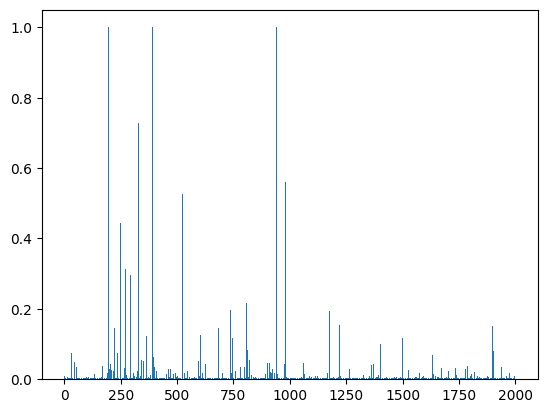

In [21]:
plt.bar(result_csv['user_id'], result_csv['avg_score'])
plt.show()

## Report

### Student ID and Name

- 109062135 陳家輝
- 109062335 王懷鴻
- 109062108 陳寬宸

### Model

在本次Cup中，我們首先使用了pretrained好的Sentence Embedding對新聞的headline和description做處理，並將兩者的embedding進行加權平均，作為item embedding的初始值。隨後根據user data的history，對user點擊的相關item取出它們的embedding，再做平均作為user embedding的初始值。

模型的選用上，我們首先嘗試了Tutorial中的FunkSVD，在訓練一小段時間後，忽然想到上課老師有提到BiasSVD僅僅加上了item和user的bias就可以取得重大的突破，隨後便稍微修改了一下code將模型變成BiasSVD。

### Data Collection

在對模型進行訓練幾十個epochs後，我們便會跑一次training environment，在與環境互動的過程中做data collection，其中若是有點擊的item，我們就將該item記錄在該user的history裡面，若是都沒有點擊，則將五個item記錄在該user的non_clicks裡面。等到一次training environment互動都結束，就將這些收集到的資訊寫回到json裡面做永久保存。

隨後在做新的訓練時，我們會再初始化一次interaction matrix，將更新過的user_data.json重新讀出，對點擊過的history設為1，沒有點擊的non_clicks設為0，並且我們發現，有的時候user點過的item，在後續又被推薦時可能會出現不點擊的情況，意思就是同一個item可能會同時出現在history和non_clicks，此時我們的做法就是將同時出現的item認定為user會偏好的，只是可能看過了所以不會想再看一次，那麼在設值的時候會將其設為1。

### Training

在訓練上，我們有分為offline和online的learning方式。

- Offline
    
    Offline learning是基於user_data，對interaction matrix進行幾十個epochs的訓練後，會執行一次training environment進行互動，並且在過程中做data collection。這樣跑完1 round後，對更新過的資料重新初始化interaction matrix，再做新的訓練。

- Online

    Online learning是基於在training environment互動時，對user做出的response進行更新。若user有點擊item，則對該user和該item的embeddings進行正向更新，而若user都沒有點擊任何item，則對該五個items對應到該user的embeddings進行負向更新。每互動一次就更新一次，並且僅對特定的user和item進行更新。

- Hybrid

    Offline的好處是訓練較快，較容易取得一定的成果，但缺點是需要收集到很多的資訊才可以支撐的起訓練，否則很容易overfitting。在初期訓練的時候，因為很常發生overfitting的情況，導致training enviroment的互動很快就結束，在data collection上獲得不了太多的新資訊。

    Online的好處則是訓練比較穩定，因為是互動一次就更新一次，對於user的偏好不會太快就擬合，呈現一個比較平滑的訓練趨勢，所以在推薦的過程中往往比Offline可以在環境中待得更久。但是壞處就是收斂的速度很慢。

    所以我們嘗試結合兩者進行Hybrid的訓練。首先基於interaction matrix做Offline訓練一定的epochs，使模型在目前的資訊上具有一定的表現，再進入training environment中進行Online的訓練，幫助模型較平滑的進行更新避免overfitting。在與環境互動結束後，同樣將收集到的資訊寫回json，並在下一次訓練時重新初始化interaction matrix，再重複Offline和Online的訓練。

### Recommendation

在推薦的過程中，我們發現有的時候user點擊過的item在後續重新被推薦時，該user又會不點擊了，我們猜測可能是因為看過的item再次被推薦時user不會想再看一次，所以我們修改了我們的推薦策略，讓其可以基於user點擊過的記錄，不再推薦已經點擊過的item，從而發掘更多user的偏好。我們在每一次訓練時會重新初始化user history為原始僅具有3個點擊記錄的data，而在互動的過程中不斷將點擊item給記錄下來，避免重複推薦。

具體的做法就是在推薦時會預測該user對於所有item的評分，我們將那些點擊過的item的分數手動設成很低，讓其不會再被推薦。此一做法比起一開始只推薦預測評分高的item而不考慮重複性的方法來的好上很多，取得了很重大的突破。

## Scoring

- Ranking of **private** leaderboard of the Kaggle competition. (80%)
- Report. (20%)

### How is the Score For Ranking Calculated:

We will calculate the MAE (Mean Absolute Error) between your submitted `output.csv` and a "ground-truth" of all 1s. The lower the better.

### Your Report Should Contain:

- Models you have tried during the competition. Briefly describe the main idea of the model and the reason why you chose that model.
- List the experiments you have done. For instance, data collecting, utilizing the user / item datasets, hyperparameters tuning, training process, and so on.
- Discussions, lessons learned, or anything else worth mentioning.
- **Ensure your report notebook contains your training and testing code. We will re-run your code if we find your score on Kaggle suspicious.**

Please name your report as `DL_comp4_{Your Team name}_report.ipynb.` and submit your report to the eeclass system before the deadline.

## What You Can Do

- Implement any recommender models.
- Collect data through accessing the **public methods provided by the environments** (i.e. methods listed in the ***Environment Public Methods*** section) and train your model.
- Use the provided user history data (`dataset/user_data.json`) and item text description data (`dataset/item_data.json`) as auxiliary data to aid your model training.
- Update the model during one testing episode while **following the rules mentioned in the ***Testing*** section.**
- You can use a pretrained text encoder if you need text embeddings for the item text descriptions. **(This is the only part you can use a pretrained model in this competition.)**

## What You CAN NOT Do

- Use any dataset other than the provided ones. Using the original News Category Dataset is also prohibited.
- Use any pretrained recommender models.
- Plagiarize other teams' work.
- Hack our simulation environments. Any attempt of accessing or modifying the data files in the `evaluation` directory, modifying the source code of the environments, accessing or modifying the private attributes and methods (i.e. methods and attributes not listed in the ***Environment Public Methods*** section), not following the rules in the ***Testing*** section, or any other forbidden actions mentioned in the previous section of the notebook will be regarded as cheating.

## Competition Timeline

- 2024/01/08 (Mon): Competition launched.
- 2024/01/15 (Mon) 08:00 (TW): Competition deadline.
- 2024/01/16 (Tue) 12:00 (TW): Report deadline.
- 2024/01/16 (Tue) 15:30 (TW): Top-3 teams sharing.

## References

1. Misra, Rishabh. "News Category Dataset." arXiv preprint arXiv:2209.11429 (2022).
2. Misra, Rishabh and Jigyasa Grover. "Sculpting Data for ML: The first act of Machine Learning." ISBN 9798585463570 (2021).